# Results Analysis #
--------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
import seaborn as sns
import sys
import os
import warnings

warnings.filterwarnings('ignore')
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino'], 'size': 11})
CSV_PATH = "./data/P4_N4096000_STRONG_LOCAL/"
FW_PATH = "./data/framework_comparison/"
POL_PATH = "./data/policy_comparison/"
GLOB_PATH = "./data/global_queue/"
IN_PATH = "./data/input_comparison/"

In [120]:
files = os.listdir(CSV_PATH)
forks = pd.concat([pd.read_csv(os.path.join(CSV_PATH, f)) for f in files if f.startswith("S0") and f.endswith(".csv")])
joins = pd.concat([pd.read_csv(os.path.join(CSV_PATH, f)) for f in files if f.startswith("S1") and f.endswith(".csv")])
forks = forks.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })
joins = joins.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })

display(forks.head(20))
display(joins.head(20))

,Time (ms),ID,Code,info1,info2
0,77.3672,0,CREATE,0.000000,0.000
0,77.4164,1,CREATE,0.000000,1.000
0,77.4516,2,CREATE,0.000000,2.000
0,77.4806,3,CREATE,0.000000,3.000
1,77.5937,0,SC_BGN,0.000000,NaN
2,77.5991,0,CHI_NO,3.000000,0.455
3,77.6063,0,SC_GLB,NaN,NaN
1,77.6792,3,RT_BGN,NaN,NaN
1,77.6799,1,RT_BGN,NaN,NaN
2,77.6862,3,RT_GLB,0.000000,NaN


,Time (ms),ID,Code,info1,info2
0,77.5074,0,CREATE,1.0,0.0
0,77.5317,1,CREATE,1.0,1.0
0,77.5619,2,CREATE,1.0,2.0
0,77.5890,3,CREATE,1.0,3.0
1,77.6920,3,SC_BGN,0.0,NaN
2,77.6960,3,SC_LOC,NaN,NaN
3,77.7224,3,SC_BGN,-1.0,NaN
4,77.7267,3,SC_LOC,NaN,NaN
5,77.7426,3,SC_BGN,-2.0,NaN
6,77.7459,3,SC_LOC,NaN,NaN


## Queue Dimensions ##

In [3]:
n_ws = len(forks.ID.unique())
loc_hs = np.zeros((n_ws, len(forks)))
glob_h = np.zeros(len(forks))

last_l = np.zeros(n_ws)
last_g = 0

for i, (t, wid, code, i1, i2) in enumerate(forks.itertuples(index=False, name=None)):
    if code == "SC_LOC":
        last_l[wid] += 1
    elif code == "RT_LOC":
        last_l[wid] -= 1
    elif code == "SC_GLB":
        last_g += 1
    elif code == "RT_GLB":
        last_g -= 1
    
    loc_hs[:, i] = last_l
    glob_h[i] = last_g

In [4]:
dfs = []

for i in range(n_ws):
    local = forks[['Time (ms)']].copy()
    local['Size'] = loc_hs[i, :]
    local['Queue'] = "$W_{}$".format(i)
    dfs.append(local)

glob = forks[['Time (ms)']].copy()
glob['Size'] = glob_h
glob['Queue'] = "Global"
dfs.append(glob)

queues = pd.concat(dfs).sort_values('Time (ms)')
queues[['Size', 'Queue']].groupby('Queue').describe()

Size                                             
          count      mean       std  min  25%  50%  75%  max
Queue                                                       
$W_0$   12300.0  3.791382  1.698770  0.0  3.0  4.0  5.0  9.0
$W_1$   12300.0  3.571707  1.755105  0.0  2.0  4.0  5.0  9.0
$W_2$   12300.0  3.792520  1.499234  0.0  3.0  4.0  5.0  8.0
$W_3$   12300.0  3.252927  1.531896  0.0  2.0  3.0  4.0  8.0
Global  12300.0  2.910732  1.642739  0.0  2.0  3.0  5.0  6.0

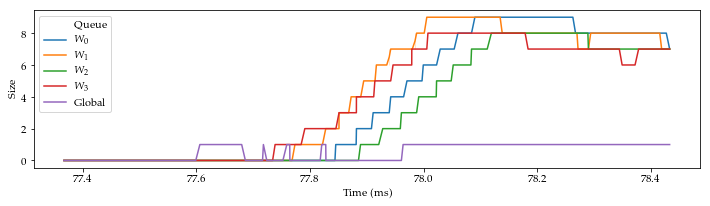

In [11]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(data=queues[:800], x='Time (ms)', y='Size', hue='Queue', hue_order=sorted(queues.Queue.unique()))
ax.legend()

plt.tight_layout()
plt.savefig("../report/figures/startup.pdf", format='pdf', bbox_inches='tight')
plt.show()

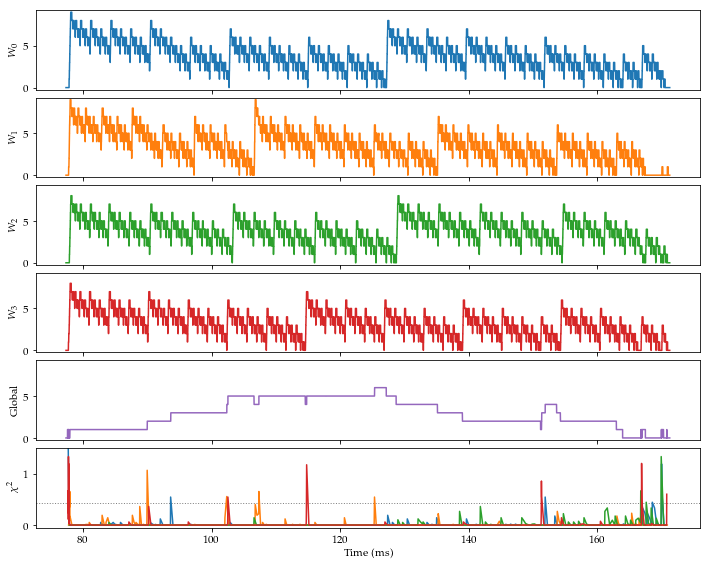

In [55]:
fig, axes = plt.subplots(n_ws + 2, 1, figsize=(10, 8), sharex=True)
max_size = queues['Size'].max()

for i, q in enumerate(sorted(queues.Queue.unique())):
    sns.lineplot(data=queues[queues.Queue == q], x='Time (ms)', y='Size', color='C{}'.format(i), ax=axes[i])
    axes[i].set_ylim((-0.25, max_size + 0.25))
    axes[i].set_ylabel(q)

chis = forks[forks.Code.apply(lambda c: c.startswith('CHI_'))].copy()
chis['info1'] = chis.apply(lambda r: 0. if r['Code'] == 'CHI_SK' else r['info1'], axis=1)

axes[n_ws+1].axhline(0.433, linestyle=':', linewidth=1., c='gray')

for i in range(n_ws):
    chis[chis.ID == i].plot(x='Time (ms)', y='info1', color='C{}'.format(i), ax=axes[n_ws+1])
    
axes[n_ws+1].set_ylabel(r'$\chi^2$')
axes[n_ws+1].get_legend().remove()
axes[n_ws+1].set_ylim((-0.05, 1.5))
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("../report/figures/queues.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Waiting Time ##
### 4 Workers ###

In [121]:
n_ws = len(forks.ID.unique())
rt_wait = np.zeros((n_ws, len(forks)), dtype=bool)
sc_wait = np.zeros((n_ws, len(forks)), dtype=bool)

last_rt = np.zeros(n_ws, dtype=bool)
last_sc = np.zeros(n_ws, dtype=bool)

for i, (t, wid, code, i1, i2) in reversed(list(enumerate(forks.itertuples(index=False, name=None)))):
    if code == "SC_GLB":
        last_sc[wid] = True
    elif code == "RT_GLB":
        last_rt[wid] = True
    elif code == "SC_BGN":
        last_sc[wid] = False
    elif code == "RT_BGN":
        last_rt[wid] = False
    
    rt_wait[:, i] = last_rt
    sc_wait[:, i] = last_sc
    
rt_wait = np.logical_or(rt_wait, np.roll(rt_wait, 1, axis=1))
sc_wait = np.logical_or(sc_wait, np.roll(sc_wait, 1, axis=1))

In [122]:
dfs = []

for i in range(n_ws):
    rt = forks[['Time (ms)']].copy()
    rt['Idle'] = rt_wait[i, :]
    rt['Type'] = 'Retrieve'
    rt['Worker'] = i
    dfs.append(rt)
    
    sc = forks[['Time (ms)']].copy()
    sc['Idle'] = sc_wait[i, :]
    sc['Type'] = 'Schedule'
    sc['Worker'] = i
    dfs.append(sc)

wait = pd.concat(dfs).sort_values('Time (ms)')
wait.head()

,Time (ms),Idle,Type,Worker
0,77.3672,False,Retrieve,0
0,77.3672,False,Retrieve,2
0,77.3672,False,Retrieve,3
0,77.3672,False,Schedule,1
0,77.3672,False,Retrieve,1


In [123]:
wait_plot = wait.copy()

wait_plot.loc[:, 'Idle'] = wait.apply(lambda r: r['Worker'] if r['Idle'] else np.nan, axis=1)
wait_plot = wait_plot.dropna()

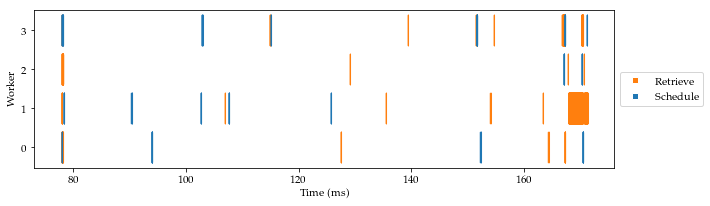

In [124]:
fig, ax = plt.subplots(figsize=(10, 3))
legend_elements = []

for t in sorted(wait_plot.Type.unique()):
    c = 'C0' if t == "Schedule" else 'C1'
    legend_elements.append(Line2D([0], [0], color='w', marker='s', markerfacecolor=c, label=t))
    
    ax.scatter(x=wait_plot[wait_plot.Type == t]['Time (ms)'], 
               y=wait_plot[wait_plot.Type == t]['Idle'], 
               marker='$|$', 
               linewidth=0, 
               s=1000,
               color=c)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Worker")
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("../report/figures/idletime_4.pdf", format='pdf', bbox_inches='tight')
plt.show()

### 64 workers ###

In [114]:
files = os.listdir(GLOB_PATH)
forks = pd.concat([pd.read_csv(os.path.join(GLOB_PATH, f)) for f in files if f.startswith("S0") and f.endswith(".csv")])
joins = pd.concat([pd.read_csv(os.path.join(GLOB_PATH, f)) for f in files if f.startswith("S1") and f.endswith(".csv")])
forks = forks.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })
joins = joins.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })

display(forks.head(20))
display(joins.head(20))

,Time (ms),ID,Code,info1,info2
0,368.094,0,CREATE,0.0,0.0
0,368.530,1,CREATE,0.0,1.0
0,368.801,2,CREATE,0.0,2.0
0,369.110,3,CREATE,0.0,3.0
0,369.398,4,CREATE,0.0,4.0
0,369.712,5,CREATE,0.0,5.0
0,369.992,6,CREATE,0.0,6.0
0,370.270,7,CREATE,0.0,7.0
0,370.645,8,CREATE,0.0,8.0
0,370.972,9,CREATE,0.0,9.0


,Time (ms),ID,Code,info1,info2
0,387.263,0,CREATE,1.0,0.0
0,387.461,1,CREATE,1.0,1.0
0,387.662,2,CREATE,1.0,2.0
0,387.844,3,CREATE,1.0,3.0
0,388.026,4,CREATE,1.0,4.0
0,388.214,5,CREATE,1.0,5.0
0,388.394,6,CREATE,1.0,6.0
0,388.588,7,CREATE,1.0,7.0
0,388.792,8,CREATE,1.0,8.0
0,388.980,9,CREATE,1.0,9.0


In [115]:
n_ws = len(forks.ID.unique())
rt_wait = np.zeros((n_ws, len(forks)), dtype=bool)
sc_wait = np.zeros((n_ws, len(forks)), dtype=bool)

last_rt = np.zeros(n_ws, dtype=bool)
last_sc = np.zeros(n_ws, dtype=bool)

for i, (t, wid, code, i1, i2) in reversed(list(enumerate(forks.itertuples(index=False, name=None)))):
    if code == "SC_GLB":
        last_sc[wid] = True
    elif code == "RT_GLB":
        last_rt[wid] = True
    elif code == "SC_BGN":
        last_sc[wid] = False
    elif code == "RT_BGN":
        last_rt[wid] = False
    
    rt_wait[:, i] = last_rt
    sc_wait[:, i] = last_sc
    
rt_wait = np.logical_or(rt_wait, np.roll(rt_wait, 1, axis=1))
sc_wait = np.logical_or(sc_wait, np.roll(sc_wait, 1, axis=1))

In [116]:
dfs = []

for i in range(n_ws):
    rt = forks[['Time (ms)']].copy()
    rt['Idle'] = rt_wait[i, :]
    rt['Type'] = 'Retrieve'
    rt['Worker'] = i
    dfs.append(rt)
    
    sc = forks[['Time (ms)']].copy()
    sc['Idle'] = sc_wait[i, :]
    sc['Type'] = 'Schedule'
    sc['Worker'] = i
    dfs.append(sc)

wait = pd.concat(dfs).sort_values('Time (ms)')
wait.head()

,Time (ms),Idle,Type,Worker
0,368.094,False,Retrieve,0
0,368.094,False,Retrieve,2
0,368.094,False,Schedule,17
0,368.094,False,Retrieve,30
0,368.094,False,Schedule,30


In [117]:
wait_plot = wait.copy()

wait_plot.loc[:, 'Idle'] = wait.apply(lambda r: r['Worker'] if r['Idle'] else np.nan, axis=1)
wait_plot = wait_plot.dropna()

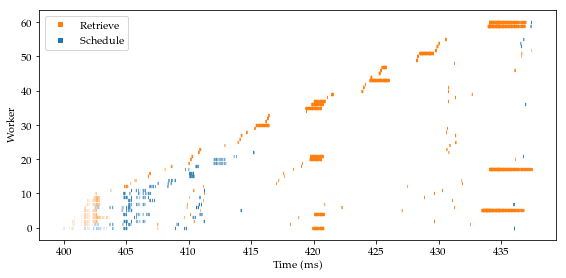

In [119]:
fig, ax = plt.subplots(figsize=(8, 4))
legend_elements = []

for t in sorted(wait_plot.Type.unique()):
    c = 'C0' if t == "Schedule" else 'C1'
    legend_elements.append(Line2D([0], [0], color='w', marker='s', markerfacecolor=c, label=t))
    
    ax.scatter(x=wait_plot[wait_plot.Type == t]['Time (ms)'], 
               y=wait_plot[wait_plot.Type == t]['Idle'], 
               marker='$|$', 
               linewidth=0, 
               s=10,
               color=c)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Worker")
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.savefig("../report/figures/idletime_64.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Preformances ##

### Policy Comparison ###

In [27]:
dfs = []
files = [ f for f in os.listdir(POL_PATH) if f.endswith('.csv')]

for f in files:
    df = pd.read_csv(os.path.join(POL_PATH, f))
    df['Policy'] = os.path.splitext(f)[0]
    dfs.append(df)

sp = pd.concat(dfs)
sp['Time $(s)$'] = sp['Time (ms)'] / 1000.
sp.head()

,Workers,Time (ms),Policy,Time $(s)$
0,1,956503,Strong,956.503
1,1,948123,Strong,948.123
2,1,939916,Strong,939.916
3,1,940215,Strong,940.215
4,1,941942,Strong,941.942


In [28]:
avg = sp[sp.Workers == 1].groupby('Policy')['Time (ms)'].mean()

sp['Scalability'] = avg[sp.Policy].values / sp['Time (ms)'].values
sp.groupby(['Workers', 'Policy']).describe()

Scalability                                                    \
                      count      mean       std       min       25%       50%   
Workers Policy                                                                  
1       Relaxed         8.0  1.000058  0.008100  0.988533  0.991950  1.003960   
        Strict          8.0  1.000041  0.006817  0.987069  0.999010  1.002073   
        Strong          8.0  1.000030  0.005849  0.988949  0.997515  0.999945   
2       Relaxed         8.0  1.882196  0.017939  1.845575  1.879670  1.889930   
        Strict          8.0  1.882147  0.008917  1.862913  1.881910  1.885262   
        Strong          8.0  1.870485  0.012197  1.845057  1.869909  1.875826   
4       Relaxed         8.0  2.795213  0.198734  2.550440  2.628189  2.814713   
        Strict          8.0  3.028304  0.109108  2.900334  2.955045  2.990888   
        Strong          8.0  3.175389  0.130752  3.024807  3.054686  3.153654   
8       Relaxed         8.0  4.493200  0.254864  4.098004  4.350795  4.429201   
        Strict          8.0  5.002494  0.178399  4.813932  4.853371  4.937728   
        Strong          8.0  5.334425  0.190234  5.025250  5.175862  5.431095   
16      Relaxed         8.0  6.232064  0.238082  5.921980  6.027102  6.257321   
        Strict          8.0  6.680713  0.352731  6.324240  6.462798  6.656168   
        Strong          8.0  6.989987  0.331431  6.348032  6.873403  6.993623   
32      Relaxed         8.0  7.792668  0.331153  7.202836  7.573844  7.917955   
        Strict          8.0  7.600202  0.374902  7.237169  7.353358  7.505670   
        Strong          8.0  7.961273  0.504027  7.180410  7.688765  7.859974   
64      Relaxed         8.0  7.745803  0.483721  6.966833  7.558609  7.746094   
        Strict          8.0  7.964022  0.547708  6.972771  7.830104  7.887085   
        Strong          8.0  8.263098  0.498035  7.358711  8.081518  8.386901   
128     Relaxed         8.0  7.584886  0.247005  7.229103  7.454583  7.519768   
        Strict          8.0  7.477821  0.516264  6.626852  7.269437  7.536214   
        Strong          8.0  7.178338  0.464219  6.232920  7.122785  7.259483   
256     Relaxed         8.0  6.814506  0.211224  6.474525  6.696667  6.777863   
        Strict          8.0  6.316952  0.334581  5.908049  6.037884  6.261941   
        Strong          8.0  6.293493  0.365767  5.653267  6.084524  6.397269   

                                    Time $(s)$                ...     \
                      75%       max      count        mean    ...      
Workers Policy                                                ...      
1       Relaxed  1.006357  1.007941        8.0  957.465750    ...      
        Strict   1.004011  1.006398        8.0  956.022750    ...      
        Strong   1.004698  1.006402        8.0  945.932875    ...      
2       Relaxed  1.894117  1.894891        8.0  508.737000    ...      
        Strict   1.886687  1.890722        8.0  507.952750    ...      
        Strong   1.877983  1.878618        8.0  505.734250    ...      
4       Relaxed  2.911215  3.095279        8.0  344.054750    ...      
        Strict   3.149523  3.158359        8.0  316.052125    ...      
        Strong   3.300019  3.350890        8.0  298.334500    ...      
8       Relaxed  4.719260  4.856387        8.0  213.694875    ...      
        Strict   5.177027  5.267749        8.0  191.319250    ...      
        Strong   5.468200  5.517477        8.0  177.527875    ...      
16      Relaxed  6.389485  6.583281        8.0  153.831875    ...      
        Strict   6.712441  7.477047        8.0  143.428250    ...      
        Strong   7.186138  7.440732        8.0  135.602125    ...      
32      Relaxed  8.043860  8.108344        8.0  123.067875    ...      
        Strict   7.688916  8.338474        8.0  126.045750    ...      
        Strong   8.296587  8.797739        8.0  119.232250    ...      
64      Relaxed  7.967901  8.464010        8.0  124.038875    ...      
 

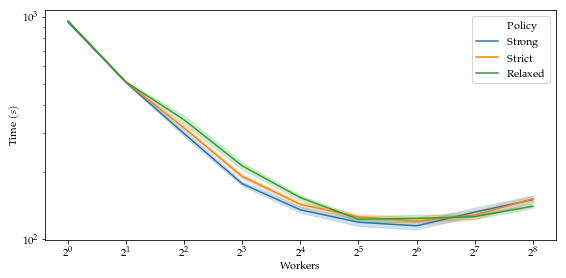

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(data=sp, x='Workers', y='Time $(s)$', hue='Policy', ax=ax)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=10)

plt.tight_layout()
plt.savefig("../report/figures/time_policy.pdf", format='pdf', bbox_inches='tight')
plt.show()

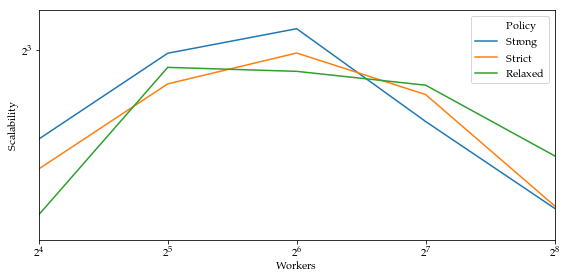

In [96]:
fig, ax = plt.subplots(figsize=(8, 4))

ideal = [i for i in range(sp.Workers.max())]
ax.set_alpha(0.1)

sns.lineplot(data=sp, x='Workers', y='Scalability', hue='Policy', ax=ax, ci=None)
ax.plot(ideal, ideal, ls='--', label='Ideal', c='gray')

ax.set_xlim((16, sp.Workers.max()))
ax.set_ylim((6, 8.5))
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)

plt.tight_layout()
plt.savefig("../report/figures/scalability_policy.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Framework Comparison ###

In [24]:
dfs = []
files = [ f for f in os.listdir(FW_PATH) if f.endswith('.csv')]

for f in files:
    df = pd.read_csv(os.path.join(FW_PATH, f))
    df['Framework'] = os.path.splitext(f)[0]
    dfs.append(df)

sf = pd.concat(dfs)
sf['Time $(s)$'] = sf['Time (ms)'] / 1000.
sf.head()

,Workers,Time (ms),Framework,Time $(s)$
0,1,27157986,DAC,27157.986
1,1,26950801,DAC,26950.801
2,1,26975706,DAC,26975.706
3,1,26915843,DAC,26915.843
4,1,26934187,DAC,26934.187


In [25]:
avg = sf[sf.Workers == 1].groupby('Framework')['Time (ms)'].mean()

sf['Scalability'] = avg[sf.Framework].values / sf['Time (ms)'].values
sf.groupby(['Workers', 'Framework']).describe()

Scalability                                             \
                        count       mean       std        min        25%   
Workers Framework                                                          
1       DAC               5.0   1.000011  0.003621   0.993701   1.000415   
        FF                5.0   1.000003  0.001787   0.997918   0.998633   
        OMP               5.0   1.000006  0.002638   0.995558   0.999622   
        TBB               5.0   1.000004  0.002155   0.996156   1.000822   
2       DAC               5.0   1.918738  0.005025   1.909989   1.919508   
        FF                5.0   1.805363  0.027161   1.769173   1.792795   
        OMP               5.0   1.854138  0.001005   1.853086   1.853121   
        TBB               5.0   1.860542  0.001419   1.858637   1.860032   
4       DAC               5.0   3.428877  0.041197   3.392778   3.394476   
        FF                5.0   3.319048  0.021849   3.296511   3.300152   
        OMP               5.0   2.563408  0.194615   2.390966   2.409527   
        TBB               5.0   3.406083  0.002354   3.404297   3.404541   
8       DAC               5.0   5.876287  0.114123   5.732412   5.822390   
        FF                5.0   5.642327  0.016591   5.623338   5.632632   
        OMP               5.0   4.249816  0.294187   3.746134   4.254980   
        TBB               5.0   5.604504  0.211171   5.333066   5.438543   
16      DAC               5.0   8.873078  0.076904   8.750371   8.850588   
        FF                5.0   8.338293  0.080946   8.247684   8.270144   
        OMP               5.0   6.933669  0.814310   5.496464   7.131891   
        TBB               5.0   8.038698  0.255661   7.673309   7.926656   
32      DAC               5.0  11.812175  0.229574  11.565719  11.691297   
        FF                5.0   9.459931  0.116596   9.360747   9.382643   
        OMP               5.0   8.410820  0.424154   7.956696   8.285543   
        TBB               5.0  10.502078  0.283973  10.075431  10.431863   
64      DAC               5.0  14.076305  0.150060  13.929609  13.953239   
        FF                5.0   7.771621  0.108602   7.581758   7.783508   
        OMP               5.0   9.215330  0.562362   8.514568   8.797594   
        TBB               5.0  11.695784  0.554435  10.938106  11.331738   
128     DAC               5.0  14.708052  0.249848  14.270744  14.736466   
        FF                5.0   4.464362  0.098671   4.352571   4.398024   
        OMP               5.0   6.547085  1.385429   4.534048   5.661846   
        TBB               5.0  11.039357  2.013653   8.840319   8.987209   
256     DAC               5.0   6.838309  1.638933   5.217015   5.360126   
        FF                5.0   0.906468  0.602261   0.310402   0.403243   
        OMP               5.0   3.678889  0.319547   3.384127   3.474080   
        TBB               5.0   6.500065  2.218254   3.989012   4.170727   

                                                   Time $(s)$              \
                         50%        75%        max      count        mean   
Workers Framework                                                           
1       DAC         1.001340   1.001957   1.002640        5.0  26986.9046   
        FF          0.999941   1.001331   1.002191        5.0  26224.4600   
        OMP         1.001446   1.001509   1.001893        5.0  25698.1160   
        TBB         1.000921   1.000924   1.001196        5.0  25627.9164   
2       DAC         1.920322   1.921258   1.922611        5.0  14065.0046   
        FF          1.808386   1.813596   1.842863        5.0  14528.4980   
        OMP         1.854529   1.854569   1.855386        5.0  13859.8732   
        TBB         1.860247   1.861450   1.862345        5.0  13774.4424   
4       DAC         3.410542   3.470127   3.476464        5.0   7871.3842   
        FF          3.315896   3.336830   3.345852        5.0   7901.4722   
        OMP         2.468079   2.767126   2.781343  

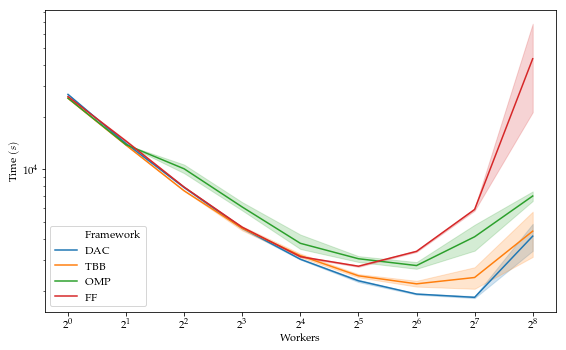

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=sf, x='Workers', y='Time $(s)$', hue='Framework', ax=ax)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=10)

plt.tight_layout()
plt.savefig("../report/figures/time_framework.pdf", format='pdf', bbox_inches='tight')
plt.show()

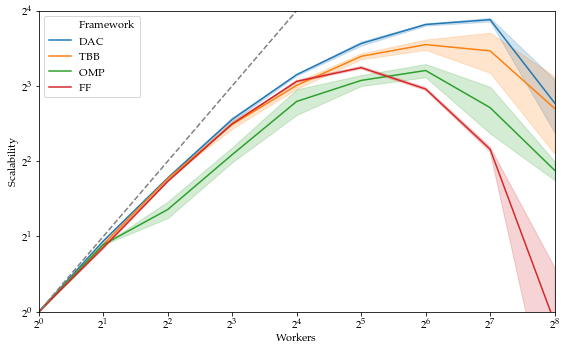

In [142]:
fig, ax = plt.subplots(figsize=(8, 5))

ideal = [i for i in range(sf.Workers.max())]

sns.lineplot(data=sf, x='Workers', y='Scalability', hue='Framework', ax=ax, ci='sd')
ax.plot(ideal, ideal, ls='--', label='Ideal', c='gray')

ax.set_xlim((1, sf.Workers.max()))
ax.set_ylim((1, 16))
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)

plt.tight_layout()
plt.savefig("../report/figures/scalability_framework.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Input Comparison ##

In [2]:
dfs = []
dirs = [ f for f in os.listdir(IN_PATH) if os.path.isdir(os.path.join(IN_PATH, f))]
files = [ f for f in os.listdir(IN_PATH) if f.endswith('.csv')]

for alg in ['Mergesort', 'Quicksort']:
    dirs = [ f for f in os.listdir(os.path.join(IN_PATH, alg.lower())) if os.path.isdir(os.path.join(IN_PATH, alg.lower(), f))]
    
    for d in dirs:
        files = [ f for f in os.listdir(os.path.join(IN_PATH, alg.lower(), d)) if f.endswith('.csv')]

        for f in files:
            df = pd.read_csv(os.path.join(IN_PATH, alg.lower(), d, f))
            df['Framework'] = os.path.splitext(f)[0].upper()
            df['Input Size'] = d
            df['Algorithm'] = alg
            dfs.append(df)

si = pd.concat(dfs)
si['Time $(s)$'] = si['Time (ms)'] / 1000.
si.head()

,Workers,Time (ms),Framework,Input Size,Algorithm,Time $(s)$
0,1,2406484,OMP,10000000,Mergesort,2406.484
1,1,2357665,OMP,10000000,Mergesort,2357.665
2,1,2367247,OMP,10000000,Mergesort,2367.247
3,1,2367635,OMP,10000000,Mergesort,2367.635
4,1,2356734,OMP,10000000,Mergesort,2356.734


In [3]:
si.groupby(['Algorithm', 'Workers', 'Input Size', 'Framework']).describe()

Time $(s)$                          \
                                            count        mean         std   
Algorithm Workers Input Size Framework                                      
Mergesort 1       10000000   DAC              5.0   2402.9738   23.218468   
                             FF               5.0   2440.4132   31.486974   
                             OMP              5.0   2371.1530   20.406778   
                             TBB              5.0   2355.3100   18.630930   
                  100000000  DAC              5.0  26224.9142   46.756828   
                             FF               5.0  26282.0004   34.743083   
                             OMP              5.0  25741.9812   31.602689   
                             TBB              5.0  25679.6058   29.327223   
                  20000000   DAC              5.0   4979.6372   29.773634   
                             FF               5.0   5000.2074   25.680249   
                             OMP              5.0   4877.7972   17.886665   
                             TBB              5.0   4832.3826   16.590798   
                  50000000   DAC              5.0  12763.0968   52.379507   
                             FF               5.0  12809.4732   41.358305   
                             OMP              5.0  12498.5278   23.984026   
                             TBB              5.0  12487.7010   24.048628   
          2       10000000   DAC              5.0   1304.3618    8.332479   
                             FF               5.0   1371.3980   13.018477   
                             OMP              5.0   1280.4110    5.459459   
                             TBB              5.0   1267.0086    4.631379   
                  100000000  DAC              5.0  14055.6586   28.971519   
                             FF               5.0  14626.2034   95.912532   
                             OMP              5.0  13864.1784    8.798127   
                             TBB              5.0  13750.8994   11.033882   
                  20000000   DAC              5.0   2674.6292    4.819067   
                             FF               5.0   2790.5396   37.363043   
                             OMP              5.0   2627.9790    5.194274   
                             TBB              5.0   2608.3594    3.178636   
                  50000000   DAC              5.0   6849.0244   16.236062   
                             FF               5.0   7093.8324  126.080396   
...                                           ...         ...         ...   
Quicksort 128     10000000   OMP              5.0    401.4110   20.238465   
                             TBB              5.0    344.3120   39.954881   
                  100000000  DAC              5.0   3508.2346  364.664746   
                             FF               5.0   6103.2676  201.226112   
                             OMP              5.0   3842.0986  245.252211   
                             TBB              5.0   3248.8598  249.184270   
                  20000000   DAC              5.0    760.0132   58.529649   
                             FF               5.0   1196.3216   61.743105   
                             OMP              5.0    778.6354   68.240200   
                             TBB              5.0    680.3714   86.656821   
                  50000000   DAC              5.0   1710.0974  188.663087   
                             FF               5.0   3022.2892  102.208201   
                             OMP              5.0   1792.5428   37.774568   
                             TBB              5.0   1696.3148  200.475730   
          256     10000000   DAC              5.0    397.9394   33.906127   
                             FF               5.0   1612.8594  121.817585   
                             OMP              5.0    652.5636   27.840447   
                             TBB              5.0    374.9338   63.777556   
                  100000000  DAC   

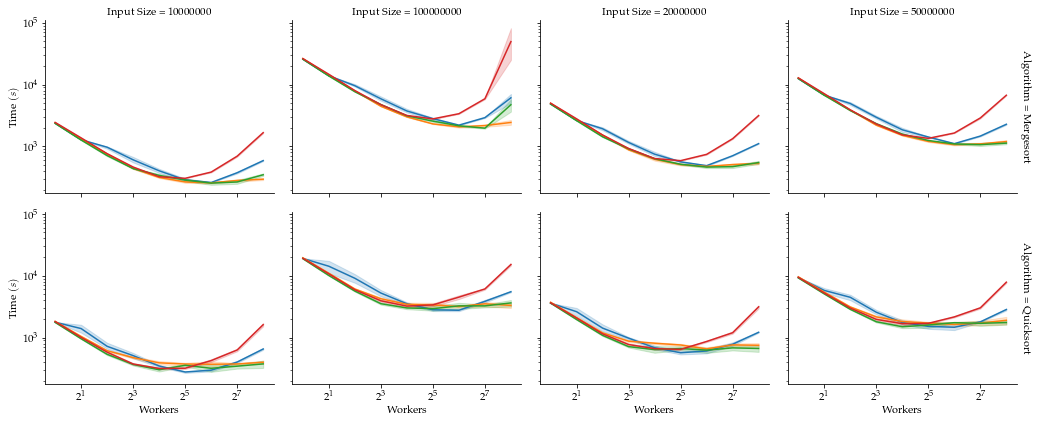

In [4]:
# fig, ax = plt.subplots(figsize=(8, 5))

g = sns.FacetGrid(si, 
                  col='Input Size', row='Algorithm', hue='Framework', 
#                   col_order=['1M', '2M', '5M', '10M'],
                  sharex=True, sharey=True, 
                  height=3, aspect=1.2,
                  legend_out=True,
                  margin_titles=True)
g = g.map(sns.lineplot, 'Workers', 'Time $(s)$')

for row in g.axes:
    for ax in row:
        ax.set_xscale('log', basex=2)
        ax.set_yscale('log', basey=10)

plt.tight_layout()
plt.savefig("../report/figures/time_input.pdf", format='pdf', bbox_inches='tight')
plt.show()

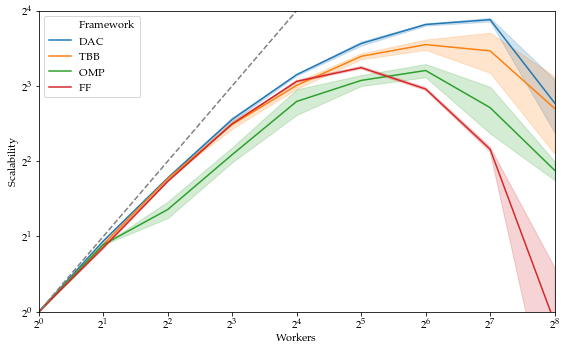

In [142]:
fig, ax = plt.subplots(figsize=(8, 5))

ideal = [i for i in range(sf.Workers.max())]

sns.lineplot(data=sf, x='Workers', y='Scalability', hue='Framework', ax=ax, ci='sd')
ax.plot(ideal, ideal, ls='--', label='Ideal', c='gray')

# ax.set_xlim((1, sf.Workers.max()))
# ax.set_ylim((1, 16))
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)

plt.tight_layout()
plt.savefig("../report/figures/scalability_framework.pdf", format='pdf', bbox_inches='tight')
plt.show()

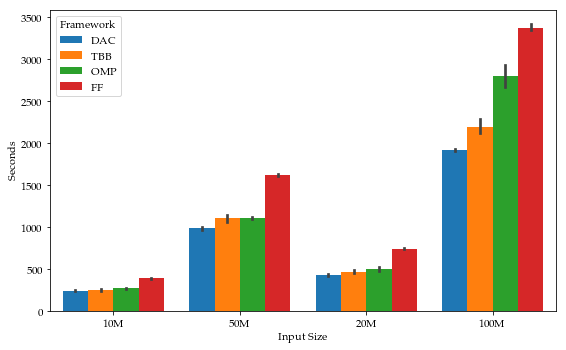

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(data=si[si.Workers == 64], x='Input Size', y='Seconds', hue='Framework', saturation=1., ax=ax)

plt.tight_layout()
plt.savefig("../report/figures/input_comparison.pdf", format='pdf', bbox_inches='tight')
plt.show()